<a href="https://colab.research.google.com/github/JanMeow/ML-cases/blob/main/0817_SAM_Perspective_Adjustment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Path Set up

In [2]:
img_0 = "1qPYq5wf1pE72mN5meuBU6GRatGd6lz78"
img_1 = "1pC3AbQwWg2Ak0Jq1zKGAukIH-1sMViRK"
img_2 = "1uo8C7CrxglnsglbvW_riFrAQiAzbTsWG"
img_3 = "1RqCVsiY0oGUZ0zFUMxG5MyyZgmH7wNJU"

mask_0 = "1wS6o9dar-kaYHHWNH_aOaaQyDpR50RwA"
mask_1 = "1CIvPl0smPgpREoNwiZtodvVGLLSbq8Tf"
mask_2 = "1TfmxxFLD3voLeYtLVomkOoU8o0yy05dx"
mask_3 = "1Mx3ZibAxoF4HcLyYS7zMyWNxMSzn8-vJ"

!gdown --id $img_3 --output window.jpg
!gdown --id $mask_3 --output window_mask.jpg
!gdown --id $img_0 --output window_test.jpg

train_img = "window.jpg"
train_mask = "window_mask.jpg"
test_img = "window_test.jpg"

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1RqCVsiY0oGUZ0zFUMxG5MyyZgmH7wNJU
To: /content/window.jpg
100% 28.9k/28.9k [00:00<00:00, 58.9MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Mx3ZibAxoF4HcLyYS7zMyWNxMSzn8-vJ
To: /content/window_mask.jpg
100% 7.43k/7.43k [00:00<00:00, 34.8MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com

## Installing PerSAM

In [3]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.1 MB/s eta 0:00:00


##Load Model

In [4]:
from transformers import AutoProcessor, SamModel
# from transformers import PerSamModel

processor = AutoProcessor.from_pretrained("facebook/sam-vit-huge")
# model = PerSamModel.from_pretrained("facebook/sam-vit-huge")
model = SamModel.from_pretrained("facebook/sam-vit-huge")

##Load Reference Image and mask

In [5]:
from pathlib import Path
train_img = Path('/content/window_mask.jpg')
original_img = Path('/content/window.jpg')

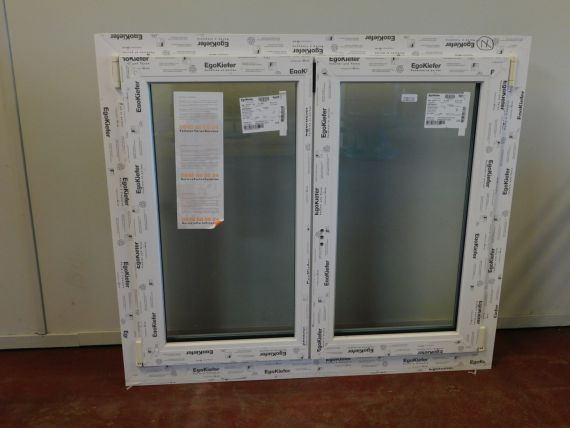

In [6]:
from PIL import Image

original_img = Image.open(original_img).convert("RGB")
original_img

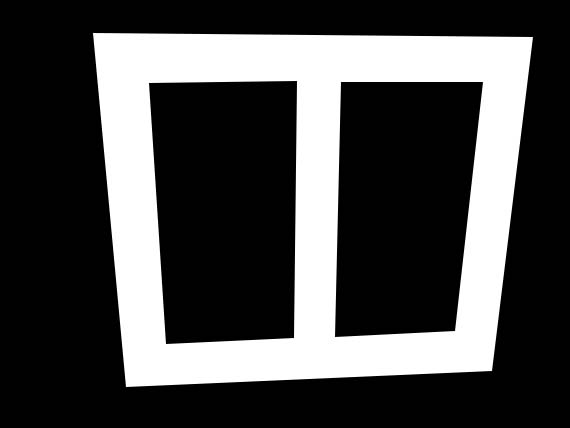

In [7]:
from huggingface_hub import hf_hub_download
from PIL import Image

ref_image = Image.open(train_img).convert("RGB")
ref_image

In [8]:
from PIL import Image
import numpy as np

numpy_array = np.array(ref_image)
print(numpy_array.shape)

(428, 570, 3)


In [9]:
numpy_array[0,0,:]

array([1, 1, 1], dtype=uint8)

In [10]:
crop = np.full_like(a=numpy_array, fill_value = 1,dtype= int)

In [11]:
mismatch_mask = numpy_array[...,-1] != crop[...,-1]
mismatched_pixel = np.argwhere(mismatch_mask)
print(mismatched_pixel)

[[ 32  88]
 [ 32  89]
 [ 32  90]
 ...
 [391 197]
 [391 198]
 [391 199]]


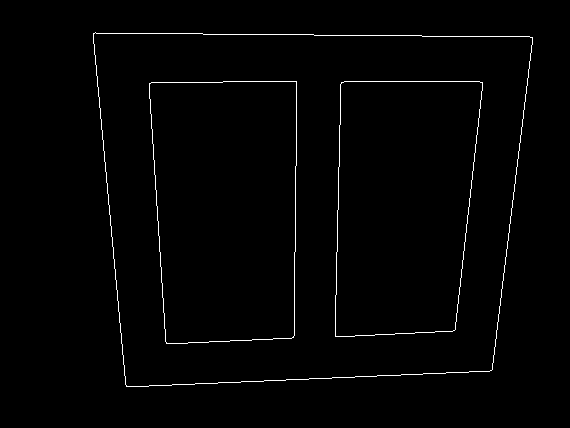

In [12]:
import cv2
from google.colab.patches import cv2_imshow
#convert to grayscale
img_gray =cv2.cvtColor(numpy_array, cv2.COLOR_BGR2GRAY)
#Blur the image for better edge detection
img_blur = cv2.GaussianBlur(img_gray, (3,3),0)

# Canny Edge Detection
edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200) # Canny Edge Detection
cv2_imshow(edges)

In [13]:
edges.shape

(428, 570)

In [14]:
pixel = np.where(edges!=[0])
pixel

(array([ 32,  33,  33, ..., 386, 386, 386]),
 array([ 95,  93,  94, ..., 146, 147, 148]))

In [70]:
import numpy as np

coordinate_array = np.column_stack((pixel[0], pixel[1]))
coordinate_array

array([[ 32,  95],
       [ 33,  93],
       [ 33,  94],
       ...,
       [386, 146],
       [386, 147],
       [386, 148]])

In [71]:

# Find the minimum and maximum values of x and y coordinates
min_x = np.min(coordinate_array[:, 0])
max_x = np.max(coordinate_array[:, 0])
min_y = np.min(coordinate_array[:, 1])
max_y = np.max(coordinate_array[:, 1])

# Calculate the corners of the rectangle/square
# bottom_left = (min_x, min_y)
# bottom_right = (max_x, min_y)
# top_left = (min_x, max_y)
# top_right = (max_x, max_y)


top_left = (min_x, min_y)
top_right = (max_x, min_y)
bottom_left = (min_x, max_y)
bottom_right = (max_x, max_y)
# top_left = (min_x, min_y)
# top_right = (max_x, max_y)
# bottom_right = (max_x, min_y)
# bottom_left = (min_x, max_y)

# top_left = (min_x, max_y)
# top_right = (max_x, max_y)
# Print the corners
print("Top Left:", top_left)
print("Top Right:", top_right)
print("Bottom Left:", bottom_left)
print("Bottom Right:", bottom_right)

Top Left: (32, 93)
Top Right: (386, 93)
Bottom Left: (32, 532)
Bottom Right: (386, 532)


In [72]:
corner_coordinates = np.array([top_left, top_right, bottom_right, bottom_left])
corner_coordinates[:,0]

array([ 32, 386, 386,  32])

In [73]:
corner_coordinates

array([[ 32,  93],
       [386,  93],
       [386, 532],
       [ 32, 532]])

In [20]:
#Perspective transformation
import numpy
import cv2

#The corrindates of distorted window frame due to perspective
edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200)

# perspective_corners = np.array([bottom_left, bottom_right, top_right, top_left],  dtype=np.float32)
perspective_corners = np.array([bottom_left, bottom_right, top_right, top_left],  dtype=np.float32)


#Actual dimension
actual_width = 150
actual_height = 150

# Front elevation coordinates of the rectangle (4 corners)
front_elevation_corners = np.array([(0, 0), (actual_width, 0), (actual_width, actual_height), (0, actual_height)], dtype=np.float32)


#Transformation Matrix
transformation_matrix = cv2.getPerspectiveTransform(perspective_corners, front_elevation_corners)

In [80]:
transformed = cv2.perspectiveTransform(perspective_corners.reshape(-1, 1, 2), transformation_matrix).reshape(-1,2)

In [112]:
#Transform entire edge detection
edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200) # Canny Edge Detection

transformed_edges = cv2.perspectiveTransform(np.array(edges, dtype = np.float32).reshape(-1, 1, 2), transformation_matrix)

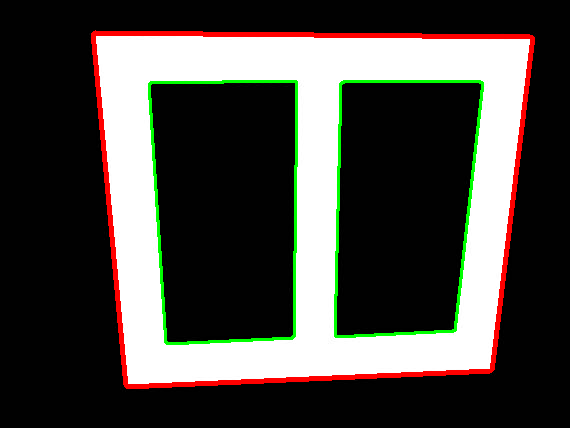

In [142]:
import cv2
import numpy as np

# Load the image
img_blur = cv2.GaussianBlur(img_gray, (3,3),0)
edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200)
original_img = np.array(ref_image)

# Find external contours in the image
ex_contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
in_contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)


# Convert the contours to the desired format
ex_vertices = []
in_vertices = []
for contour in ex_contours:
    vertices = contour.reshape(-1, 2).tolist()
    ex_vertices.append(vertices)

for contour in in_contours:
  vertices = contour.reshape(-1, 2).tolist()
  in_vertices.append(vertices)

# Draw contours on the original image
cv2.drawContours(original_img, in_contours, -1, (0, 255, 0), 2)
cv2.drawContours(original_img, ex_contours, -1, (0, 0, 255), 3)


# Display the image with contours
cv2_imshow(original_img)

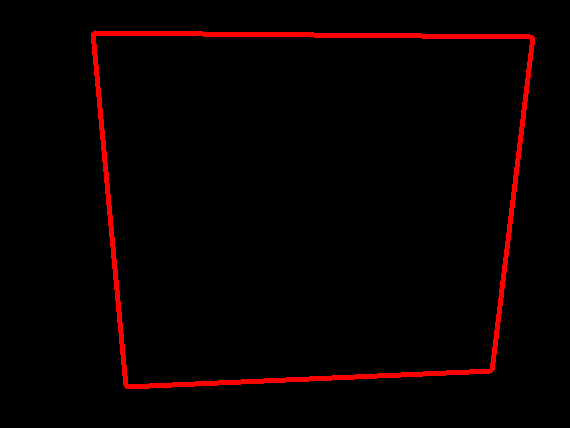

In [177]:
import cv2
import numpy as np

# Load the image
img_blur = cv2.GaussianBlur(img_gray, (3, 3), 0)
edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200)

# Find external contours in the image
ex_contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
in_contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# Create a black canvas
height, width = edges.shape
black_canvas = np.zeros((height, width,3), dtype=np.uint8)

# Draw contours on the black canvas
cv2.drawContours(black_canvas, ex_contours, -1, (0, 0, 255), 3)

# Save the image
cv2_imshow(black_canvas)

In [178]:
gray_img = cv2.cvtColor(black_canvas, cv2.COLOR_BGR2GRAY)
corners = cv2.goodFeaturesToTrack(gray_img, 4, 0.5, 50)
corners = np.reshape(a = corners, newshape = (4,2))

In [183]:
corners

array([[128., 383.],
       [489., 368.],
       [529.,  39.],
       [ 96.,  36.]], dtype=float32)

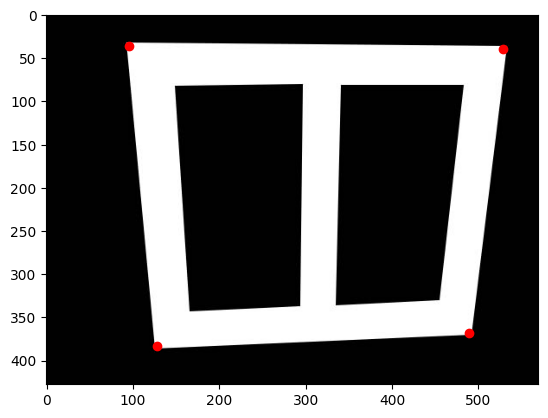

In [187]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


# Separate the x and y coordinates

x_coords = corners[:, 0]
y_coords = corners[:, 1]

# Plot the image
plt.imshow(ref_image)

# Plot the points as red dots
plt.scatter(x_coords, y_coords, color='red', marker='o')

# Show the plot
plt.show()

In [196]:
#Perspective transformation
import numpy
import cv2

# perspective_corners = np.array([bottom_left, bottom_right, top_right, top_left],  dtype=np.float32)
perspective_corners = corners

#Actual dimension
actual_width = 200
actual_height = 150

# Front elevation coordinates of the rectangle (4 corners)
front_elevation_corners = np.array([(0, 0), (actual_width, 0), (actual_width, actual_height), (0, actual_height)], dtype=np.float32)


#Transformation Matrix
transformation_matrix = cv2.getPerspectiveTransform(perspective_corners, front_elevation_corners)

In [197]:
#Get all white pixel from Canny Edges

edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200) # Canny Edge Detection
edges_array = np.array(edges, dtype=np.uint8)  # Convert to uint8

# Create a mask of all white pixels in the edges image
white_pixel_mask = edges_array == 255

# Get the positions of white pixels
white_pixel_positions = np.argwhere(white_pixel_mask)

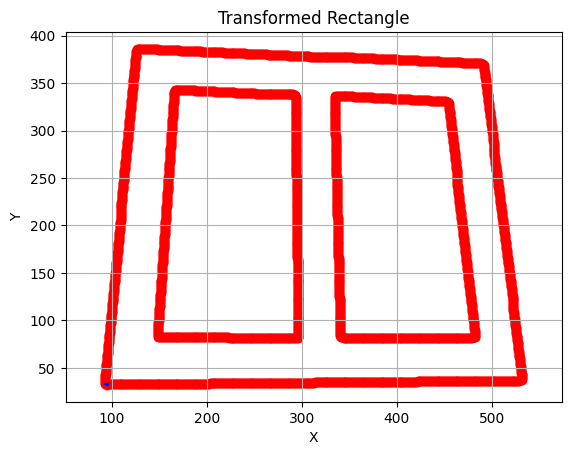

In [198]:
import numpy as np
import matplotlib.pyplot as plt

# Transformed coordinates of the rectangle
transformed_coordinates = white_pixel_positions.reshape(-1,2)[:, [1, 0]]
# Define the order of vertices to create the rectangle edges
edges = [[0, 1], [1, 2], [2, 3], [3, 0]]

# Plot the transformed rectangle
plt.figure()
for edge in edges:
    plt.plot(transformed_coordinates[edge, 0], transformed_coordinates[edge, 1], 'b-')

plt.scatter(transformed_coordinates[:, 0], transformed_coordinates[:, 1], color='red', marker='o')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Transformed Rectangle')
plt.grid()
plt.axis('equal')
plt.show()

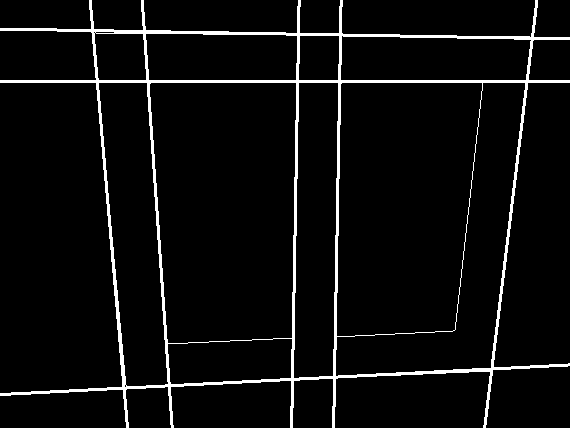

In [181]:
import cv2
import numpy as np

img_blur = cv2.GaussianBlur(img_gray, (3,3),0)
edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200)
numpy_array = np.array(edges, dtype = np.float32)

lines = cv2.HoughLines(edges,1,np.pi/180, 120)


for line in lines:
  rho, theta = line[0]
  a = np.cos(theta)
  b = np.sin(theta)

  x0 = a * rho
  y0 = b * rho
  x1 = int(x0 + 1000*(-b))
  y1 = int(y0 + 1000*(a))
  x2 = int(x0 - 1000*(-b))
  y2 = int(y0 - 1000*(a))

  cv2.line(numpy_array,(x1,y1),(x2,y2),(255,0,0),2)


cv2_imshow(numpy_array)

In [126]:
print(lines)

[[[ 5.3300000e+02  1.2217305e-01]]

 [[ 8.1000000e+01  1.5707964e+00]]

 [[-1.4200000e+02  3.0717795e+00]]

 [[-9.0000000e+01  3.0543261e+00]]

 [[ 3.4100000e+02  1.7453292e-02]]

 [[ 2.9900000e+02  1.7453292e-02]]

 [[ 2.9000000e+01  1.5882496e+00]]

 [[ 3.9400000e+02  1.5184364e+00]]]


In [108]:
def get_corners(vertices):

  coordinate_array = np.array(vertices).squeeze()

  min_x = np.min(coordinate_array[:, 0])
  max_x = np.max(coordinate_array[:, 0])
  min_y = np.min(coordinate_array[:, 1])
  max_y = np.max(coordinate_array[:, 1])


  top_right = (max_x, min_y)
  top_left = (min_x, min_y)
  bottom_right = (max_x, max_y)
  bottom_left = (min_x, max_y)

  return np.array([top_left, top_right, bottom_right, bottom_left],  dtype=np.float32)


ex_vertices = get_corners(ex_vertices)

In [100]:
ex_vertices

array([[ 93.,  32.],
       [532.,  32.],
       [532., 386.],
       [ 93., 386.]], dtype=float32)

In [26]:
in_corners = []
for i in range(len(in_vertices)):
  vertices = in_vertices[i]
  corners = get_corners(vertices)
  in_corners.append(corners)
in_corners

[array([[335., 336.],
        [482., 336.],
        [482.,  81.],
        [335.,  81.]], dtype=float32),
 array([[149., 343.],
        [296., 343.],
        [296.,  81.],
        [149.,  81.]], dtype=float32),
 array([[335., 336.],
        [482., 336.],
        [482.,  81.],
        [335.,  81.]], dtype=float32),
 array([[149., 343.],
        [296., 343.],
        [296.,  81.],
        [149.,  81.]], dtype=float32),
 array([[ 93., 386.],
        [532., 386.],
        [532.,  32.],
        [ 93.,  32.]], dtype=float32),
 array([[ 93., 386.],
        [532., 386.],
        [532.,  32.],
        [ 93.,  32.]], dtype=float32)]

In [66]:
edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200) # Canny Edge Detection
edges_array = np.array(edges, dtype=np.uint8)  # Convert to uint8

# Create a mask of all white pixels in the edges image
white_pixel_mask = edges_array == 255

# Get the positions of white pixels
white_pixel_positions = np.argwhere(white_pixel_mask)

print(white_pixel_positions)

[[ 32  95]
 [ 33  93]
 [ 33  94]
 ...
 [386 146]
 [386 147]
 [386 148]]


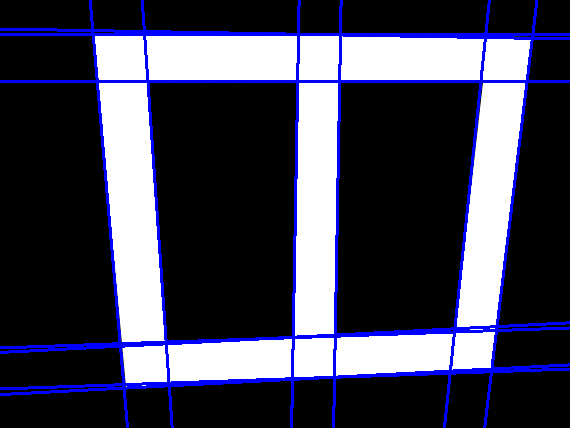

In [28]:
import cv2
import numpy as np

img_blur = cv2.GaussianBlur(img_gray, (3,3),0)
edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200)

numpy_array = np.array(ref_image)

lines = cv2.HoughLines(edges,1,np.pi/180,100)


for line in lines:
  rho, theta = line[0]
  a = np.cos(theta)
  b = np.sin(theta)

  x0 = a * rho
  y0 = b * rho
  x1 = int(x0 + 1000*(-b))
  y1 = int(y0 + 1000*(a))
  x2 = int(x0 - 1000*(-b))
  y2 = int(y0 - 1000*(a))

  cv2.line(numpy_array,(x1,y1),(x2,y2),(255,0,0),2)


cv2_imshow(numpy_array)